In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! mkdir "/content/data/"
! cp "/content/drive/My Drive/Colab Notebooks/data/kaggle/intel-image-classification.zip" "/content/data/"

In [ ]:
! unzip "/content/data/intel-image-classification.zip" -d "/content/data/"

In [ ]:
! pip install -U albumentations

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

from albumentations import (Blur, MotionBlur, MedianBlur, GaussianBlur, GaussNoise, RandomGamma,
                            HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast, JpegCompression, 
                            RandomShadow, ISONoise, Equalize, FancyPCA, CLAHE, OneOf, Compose)

In [22]:
def aug_image(image):
    p = 0.2
    aug = Compose([
                   OneOf([
                          Blur(p=p, blur_limit= (2,2)),
                          MotionBlur(blur_limit=3,p = p),
                          MedianBlur(blur_limit=3,p = p),
                          GaussianBlur(blur_limit=3,p = p),
                          GaussNoise(p = p),
                          RandomGamma(p = p)
                   ],p = p),
                   HorizontalFlip(p=p),
                   ShiftScaleRotate(shift_limit=0.06, scale_limit=0.2, rotate_limit=15, border_mode = 4, p=p),
                   RandomBrightnessContrast(p=p),
                   RandomShadow(p = p, num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=4)
    ],p=p)
    image = aug(image = image)['image']
    return image
imagegen = ImageDataGenerator(preprocessing_function=aug_image,rescale=1./255)
imagegen_ = ImageDataGenerator(preprocessing_function=None,rescale=1./255)
train = imagegen.flow_from_directory("data/seg_train/seg_train",target_size=(150,150),batch_size=128)
val = imagegen_.flow_from_directory("data/seg_test/seg_test",target_size=(150,150),batch_size=128)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [23]:
model = VGG16(include_top=False, input_shape=(150,150, 3))
for layer in model.layers:
	layer.trainable = False

x = Flatten()(model.output)
x = BatchNormalization()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(6, activation='softmax')(x)

model = Model(inputs=model.inputs, outputs=x)

# model.get_layer('block5_conv1').trainable = True
# model.get_layer('block5_conv2').trainable = True
# model.get_layer('block5_conv3').trainable = True

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [ ]:
opt = Adam(lr = 0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
epochs = 64

In [26]:
history = model.fit_generator(train, epochs=epochs, steps_per_epoch = 100, validation_data=val, verbose = 1, callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/64
100/100 [==============================] - 74s 739ms/step - loss: 63.0223 - accuracy: 0.5159 - val_loss: 1.1229 - val_accuracy: 0.6093
Epoch 2/64
100/100 [==============================] - 73s 729ms/step - loss: 1.0310 - accuracy: 0.6217 - val_loss: 0.7982 - val_accuracy: 0.7080
Epoch 3/64
100/100 [==============================] - 73s 729ms/step - loss: 1.2591 - accuracy: 0.5493 - val_loss: 1.0648 - val_accuracy: 0.5657
Epoch 4/64
100/100 [==============================] - 73s 729ms/step - loss: 1.2661 - accuracy: 0.5343 - val_loss: 0.8967 - val_accuracy: 0.5680
Epoch 5/64
100/100 [==============================] - 73s 728ms/step - loss: 1.0793 - accuracy: 0.6061 - val_loss: 0.9530 - val_accuracy: 0.6797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 6/64
100/100 [==============================] - 73s 731ms/step - loss: 0.9275 - accuracy: 0.6356 - val_loss: 0.5514 - val_accuracy: 0.7110
Epoch 7/64
100/100 [=============================

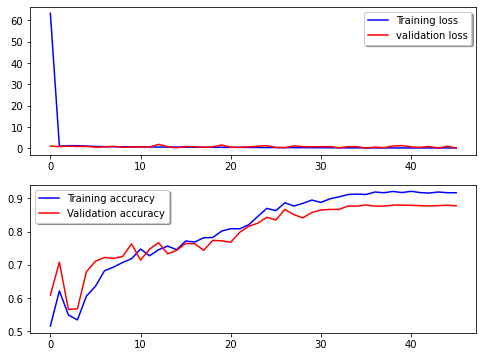

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

fig, ax = plt.subplots(2,1, figsize=(8, 6))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)